This is the stock prediction using supervised learning\(dataset: Starbacks stock 2013-2018)\
I have taken two different approach for each method 
- One step forecast
- Multistep forecast

As everyones' intutition, multistep forecase has less accuracy and loss than one step forecast. \
However, one step forecast can be not as effective as multi step forecast because it uses future value to predict target value, so people has high hope for stock price prediction has to be carefore about the result on the table and what is the practical environment for the application. 
\
I have tried \
- Simple RNN
- GRU
- LSTM
- LSTM + Global\
In conclusion, as it proved, it is not quite feasible to predict exact stock price prediction.

In [20]:
import tensorflow as tf
print('tf version: ', tf.__version__)

tf version:  2.11.0


In [21]:
from tensorflow.keras.layers import Input, LSTM, GRU, SimpleRNN, Dense, GlobalMaxPool1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [31]:
df = pd.read_csv('https://raw.githubusercontent.com/lazyprogrammer/machine_learning_examples/master/tf2.0/sbux.csv')

Wrong way

In [32]:
df.head()

,date,open,high,low,close,volume,Name
0,2013-02-08,27.920,28.325,27.920,28.185,7146296,SBUX
1,2013-02-11,28.260,28.260,27.930,28.070,5457354,SBUX
2,2013-02-12,28.000,28.275,27.975,28.130,8665592,SBUX
3,2013-02-13,28.230,28.230,27.750,27.915,7022056,SBUX
4,2013-02-14,27.765,27.905,27.675,27.775,8899188,SBUX


In [33]:
#Strat by doing the wrong thing - trying to predict the price
series = df['close'].values.reshape(-1, 1)


In [34]:
#Normalize the data
#Note:This boundary is just random approximation
scaler = StandardScaler()
scaler.fit(series[:len(series)//2])
series = scaler.transform(series).flatten()


In [35]:
##Build dataset
#LEt's see if we can use T past values to predict the next value
T = 10 
D = 1
X = []
Y = []
for t in range(len(series) - T):
  x = series[t: t+T]
  X.append(x)
  y = series[t + T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1 )# Now the data shouls be N x T x D
Y = np.array(Y)
N = len(X)
print('X_shape: ', X.shape, 'Y_shape: ', Y.shape)

X_shape:  (1249, 10, 1) Y_shape:  (1249,)


Try Autoregressive RNN model

In [36]:
i = Input(shape=(T, 1))
x = LSTM(5)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
    loss='mse',
    optimizer=Adam(0.1),
)

##Train Model
r = model.fit(
    X[:-N//2], Y[:-N//2],
    epochs=80,
    validation_data=(X[-N//2:], Y[-N//2:]),
)

Epoch 1/80
20/20 [==============================] - 3s 36ms/step - loss: 0.1837 - val_loss: 0.3487
Epoch 2/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0209 - val_loss: 0.0519
Epoch 3/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0088 - val_loss: 0.0285
Epoch 4/80
20/20 [==============================] - 0s 10ms/step - loss: 0.0068 - val_loss: 0.0275
Epoch 5/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0233
Epoch 6/80
20/20 [==============================] - 0s 11ms/step - loss: 0.0059 - val_loss: 0.0218
Epoch 7/80
20/20 [==============================] - 0s 12ms/step - loss: 0.0058 - val_loss: 0.0216
Epoch 8/80
20/20 [==============================] - 0s 14ms/step - loss: 0.0062 - val_loss: 0.0204
Epoch 9/80
20/20 [==============================] - 0s 13ms/step - loss: 0.0061 - val_loss: 0.0243
Epoch 10/80
20/20 [==============================] - 0s 16ms/step - loss: 0.0058 - val_loss: 0.0199
Epoch 11/

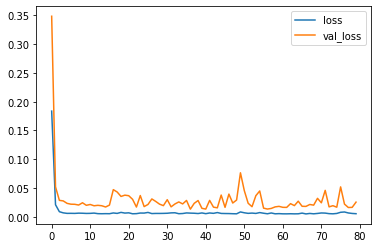

In [37]:
#Plot loss per iteration
plt.plot(r.history['loss'], label="loss")
plt.plot(r.history['val_loss'], label="val_loss")
plt.legend()

40/40 [==============================] - 0s 3ms/step
(1249, 1)


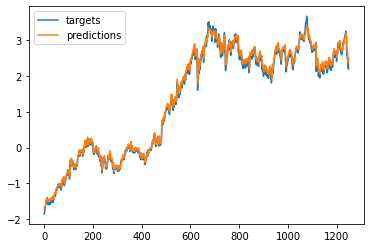

In [18]:
##One Step Forecast
outputs = model.predict(X)
print(outputs.shape)
predictions = outputs[:, 0]

plt.plot(Y, label='targets')
plt.plot(predictions, label='predictions')
plt.legend()
plt.show()

Multi step forecast

1/1 [==============================] - 0s 31ms/step


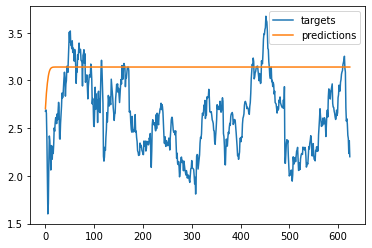

In [39]:
validation_target = Y[-N//2:]
validation_predictions = []

#last train input
last_x = X[-N//2] #1-D array of length T

while len(validation_predictions) < len(validation_target):
  p = model.predict(last_x.reshape(1, T, 1))[0,0] #1x1 aray -> scalar

  #Update the predction list
  validation_predictions.append(p)

  #make new input

  last_x = np.roll(last_x, -1)
  last_x[-1] = p

plt.plot(validation_target, label='targets')
plt.plot(validation_predictions, label='predictions')
plt.legend()
plt.show()